In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os,sys
import numpy as np
import pandas as pd
import astropy.stats as stat

import matplotlib
from   matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
import time

rc('text', usetex=True)
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sys.path.insert(1, '/home/amarins/ComponentSeparation/gmca/scripts')
import Extension4BINGO as cs
import statcosmo as statc

In [2]:
#####################################
#paths
#####################################
pathcls       = ["/home/amarins/ComponentSeparation/gmca/outputs/ICAn4nr100" ,
                 "/home/amarins/ComponentSeparation/gmca/outputs/ICAn3nr100" ,
                 "/home/amarins/ComponentSeparation/gmca/outputs/ICAn3nr50"  ,
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn5nr100",
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn4nr100",
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn3nr100",
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn4nr100",
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn4nr50" ,
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn3nr50",
                 "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn2nr50"]

dir_hi        = "21cm"        #Directory name of the cls of the 21cm reconstruction maps
dir_fg        = "foregrounds" #Directory name of the cls of the foregrounds reconstruction maps
dir_prior     = "prior"       #Directory name of the cls of the prior maps, that can be (21cm + noise) masked
dir_noise     = "noise"       #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_pure      = "pure"        #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projnoise = "projnoise"   #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_projpure  = "projpure"    #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projprior = "projprior"   #

#Noise debias model
model     = "filipe"
#Bootstrap parameters
n_samples = 1e5

#Plot 
bin_        = 10
realisation = "L5" #Warning! Choice realisation which exist in all setups

In [3]:
###################################################################################################
# Build 
###################################################################################################
for i, ipath in enumerate(pathcls):
    iname   = ipath.split("/")[-1]
    cls        = cs.loadcls(ipath,dirs=[dir_hi,dir_fg,dir_prior,dir_noise,dir_pure])
    cls_ndb    = statc.output_debias(Cls=cls, model=model, output="Cls_debias",dir_hi = dir_hi, dir_prior=dir_prior, dir_noise = dir_noise)
    cls_binned = statc.data_binned(cls_ndb)
    std_jack   = statc.jacknnife_stat(cls_binned, stat_func=np.std)
    if i==0:
        Cls        = pd.Series({iname:cls})
        Cls_ndb    = pd.Series({iname:cls_ndb})
        Cls_binned = pd.Series({iname:cls_binned})
        Std_jack   = pd.Series({iname:std_jack})
    else:
        Cls[iname]        = cls
        Cls_ndb[iname]    = cls_ndb
        Cls_binned[iname] = cls_binned
        Std_jack[iname]   = std_jack

del cls, cls_ndb, cls_binned, std_jack

In [4]:
###################################################################################################
# Choose L-realisation
###################################################################################################
for i,iname in enumerate(Cls.keys()):
    iset = np.asarray(list(Cls[iname]['21cm'].keys()))
    if i==0:
        Set = iset
    else:
        if Set.size>iset.size:
            Set = np.intersect1d(Set, iset)
        else:
            Set = np.intersect1d(iset, Set)
if realisation in Set:
    L = realisation
else:
    L = np.random.choice(Set)   

del Set, iset

In [5]:
###################################################################################################
# standard deviation by each reconstruction 
###################################################################################################
for i,iname in enumerate(Std_jack.keys()):
    std = np.zeros((len(Std_jack[iname]), len(Std_jack[iname][list(Std_jack[iname].keys())[0]])))
    for j,jname in enumerate(Std_jack[iname].keys()):
        std[j] = Std_jack[iname][jname]
    if i==0:
        Std = pd.Series({iname: std})
    else:
        Std[iname] = std

del std

In [6]:
###################################################################################################
# Chi2 by each reconstruction 
###################################################################################################
iname = list(Std.keys())[0]
for i,iname in enumerate(Std.keys()):
    xi_binned = (Cls_ndb[iname][L] - Cls[iname]['pure'][L])/Std[iname]
    xi_binned = np.square(xi_binned)
    if i==0:
        Xi2 = pd.Series({iname:xi_binned})
    else:
        Xi2[iname] = xi_binned

del xi_binned

In [7]:
###################################################################################################
# chi2 effective
###################################################################################################
for i,iname in enumerate(Xi2.keys()):
    xi2_eff = np.sum(Xi2[iname],axis=1)/float(Xi2[iname].shape[1])
    if i==0:
        Xi2_eff = pd.Series({iname:xi2_eff})
    else:
        Xi2_eff[iname] = xi2_eff

del xi2_eff

In [8]:
Xi2_eff.keys()

Index(['ICAn4nr100', 'ICAn3nr100', 'ICAn3nr50', 'GMCAn5nr100', 'GMCAn4nr100',
       'GMCAn3nr100', 'GMCAn4nr50', 'GMCAn3nr50', 'GMCAn2nr50'],
      dtype='object')

## Plots 
### $\chi^2 = \chi^2 (\mathcal{\hat{C}}_{\ell}^{\textrm{21cm}}, \Delta \nu)$

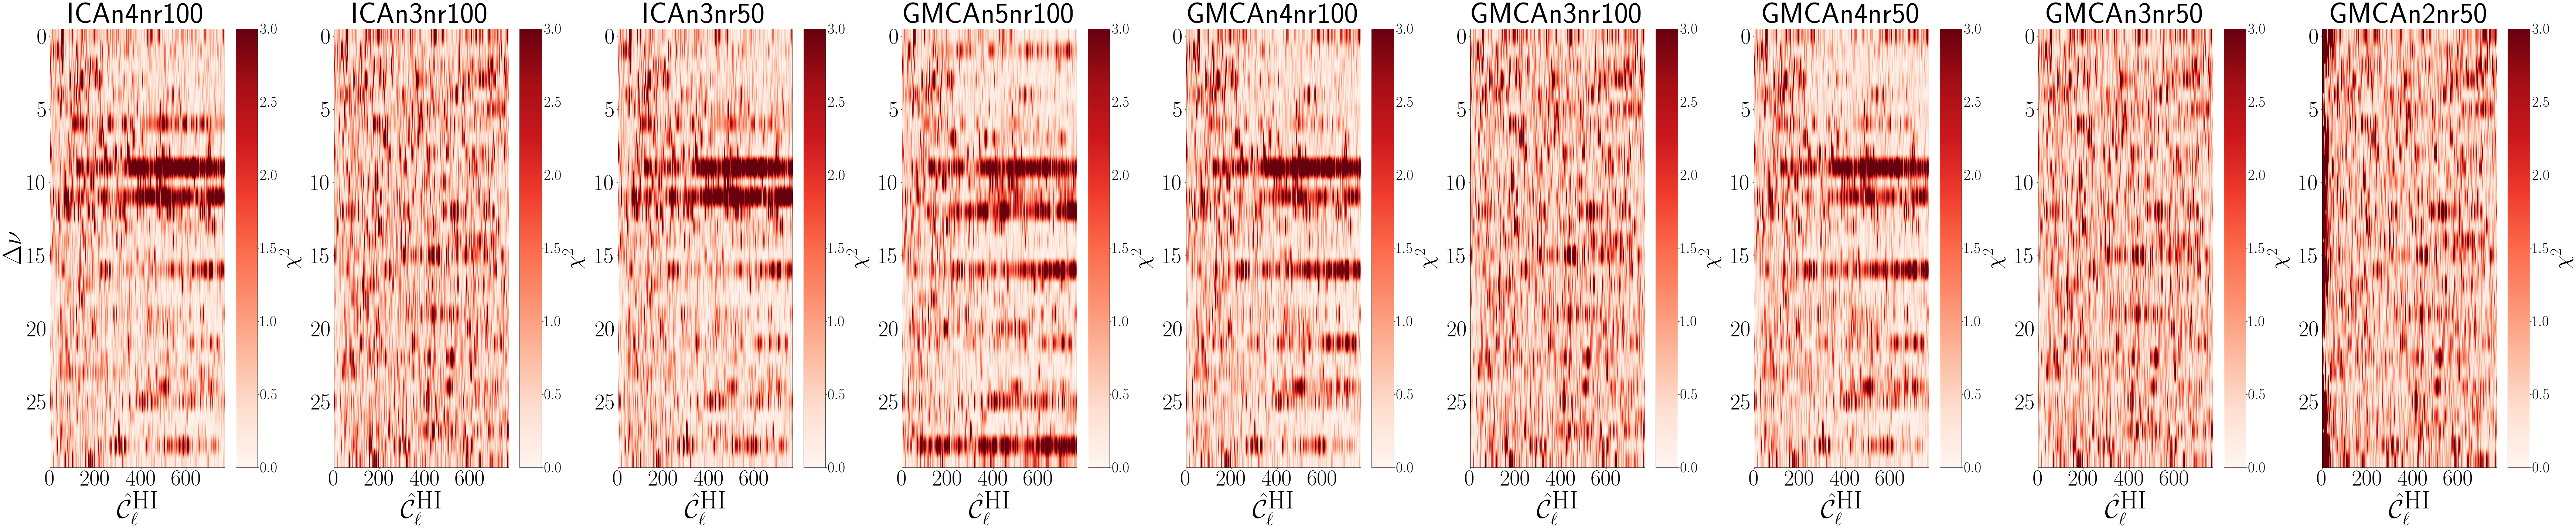

In [9]:
plt.figure(figsize=(7,12))
grid = plt.GridSpec(1,Xi2.size,right=1.5*Xi2.size, top=1.5, wspace=0.3)

for i,iname in enumerate(Xi2.keys()):
    ax = plt.subplot(grid[0,i])
    plt.imshow(Xi2[iname], aspect="auto", cmap="Reds", vmin=0, vmax=3)
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.xlabel(r"$\hat{\mathcal{C}}_{\ell}^{ \textrm{HI}}$", fontsize=70)
    if i==0: plt.ylabel(r"$\Delta \nu$", fontsize=70)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=40)
    cbar.set_label(r"$\chi^2$",horizontalalignment='right',fontsize=60)
    plt.title(iname, fontsize=80)
    

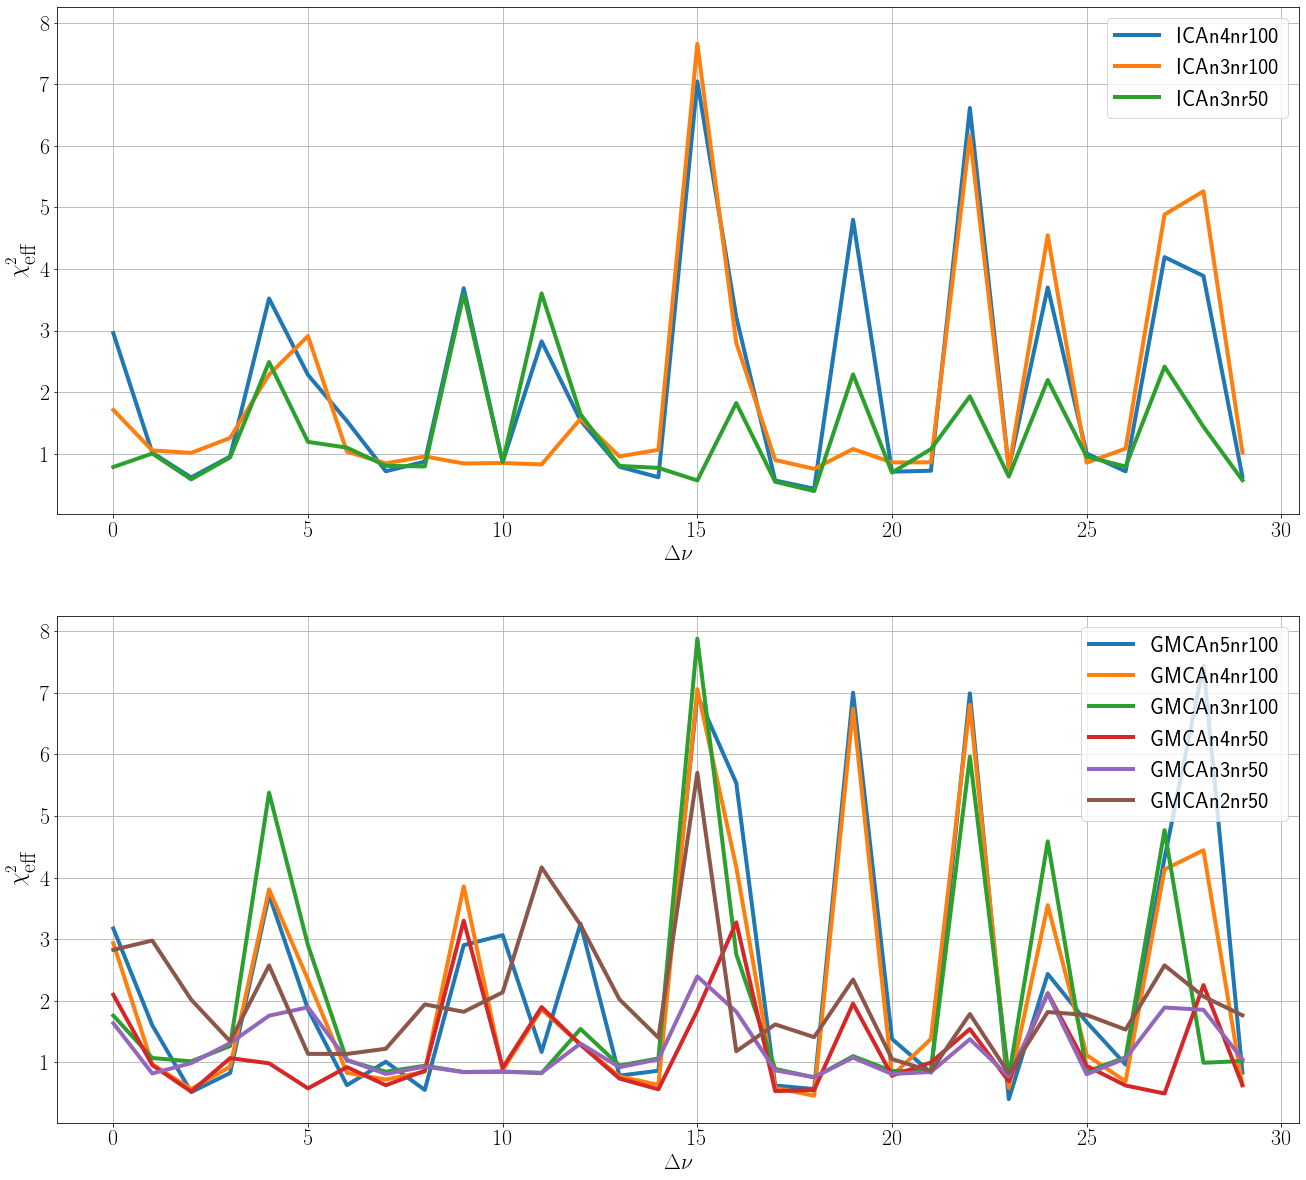

In [10]:
fig = plt.figure()
grid = plt.GridSpec(2,1,top=4,right=3)
for i, iname in enumerate(Xi2_eff.keys()):
    if iname[0]=='I':
        ax = plt.subplot(grid[0,0])
        plt.plot(Xi2_eff[iname] , label=iname, linewidth=4)
        plt.xlabel(r"$\Delta \nu$")
        plt.ylabel(r"$\chi^2_{\textrm{eff}}$")
        plt.legend()
        plt.grid(True)
    elif iname[0]=='G':
        ax1 = plt.subplot(grid[1,0], sharey=ax,sharex=ax)
        plt.plot(Xi2_eff[iname] , label=iname, linewidth=4)
        plt.xlabel(r"$\Delta \nu$")
        plt.ylabel(r"$\chi^2_{\textrm{eff}}$")
        plt.legend()
        plt.grid(True)
    else:
        pass

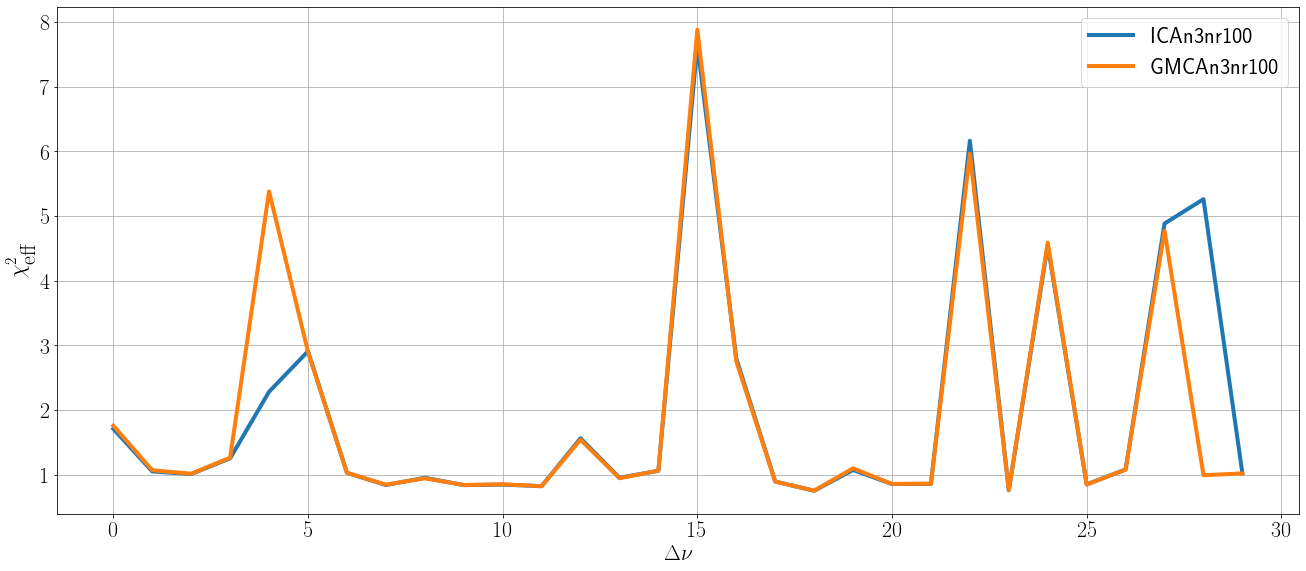

In [11]:
fig = plt.figure()
grid = plt.GridSpec(2,1,top=4,right=3)
for i, iname in enumerate(['ICAn3nr100','GMCAn3nr100']):
    ax = plt.subplot(grid[0,0])
    plt.plot(Xi2_eff[iname] , label=iname, linewidth=4)
    plt.xlabel(r"$\Delta \nu$")
    plt.ylabel(r"$\chi^2_{\textrm{eff}}$")
    plt.legend()
    plt.grid(True)

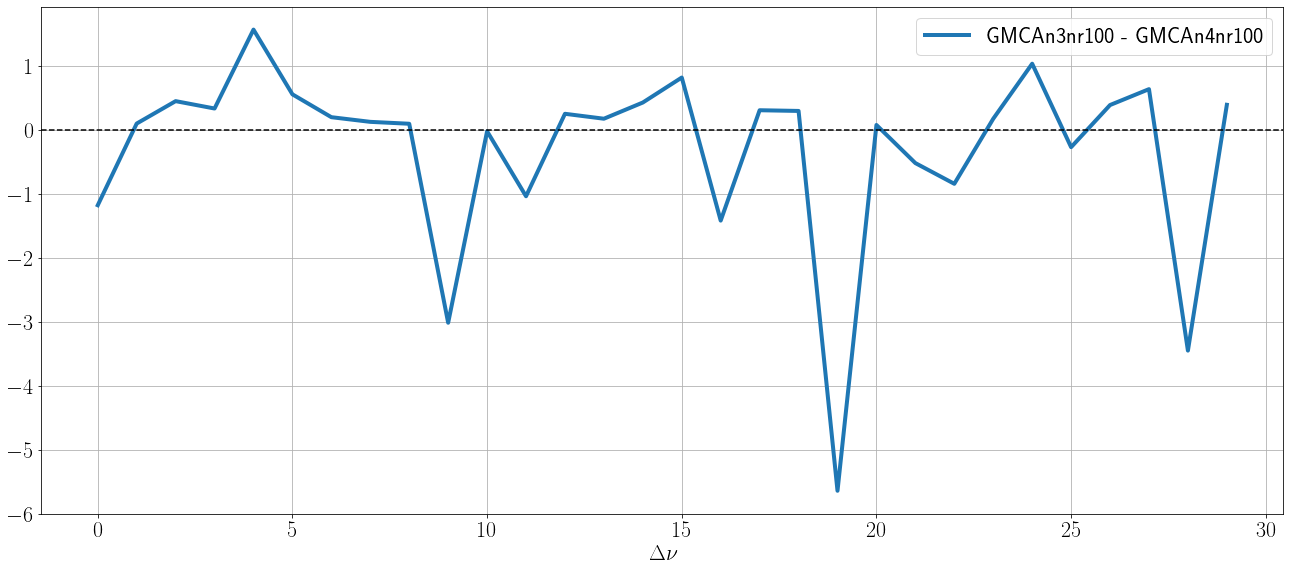

In [12]:
fig = plt.figure()
grid = plt.GridSpec(2,1,top=4,right=3)
ax = plt.subplot(grid[0,0])
iname1 = 'GMCAn3nr100'
iname2 = 'GMCAn4nr100'
plt.plot(Xi2_eff[iname1] - Xi2_eff[iname2] , label=iname1 +" - "+ iname2, linewidth=4)
plt.xlabel(r"$\Delta \nu$")
#plt.ylabel(r"$\chi^2_{\textrm{eff}}$")
plt.axhline(y=0, linestyle="dashed", color="black")
plt.legend()
plt.grid(True)